This is a notebook for developing energy flux calculations.

Energy Flux:

$\vec{F} = <\vec{u}p> $ where $<>$ means average over wave period.

Then we can get a baroclinic and barotropic energy flux by substituting baroclinc and barotropic expressions for $\vec{u}$ and $p$.

For example, (Cummins and Oey, 1996)

$p_{bt} = \rho_0g\eta$ 

and

$\frac{\partial p_{bc}}{\partial t} = -\rho_0 \int_0^z wN^2 dz^*$.

The baroclinic and barotropic velocities are set up in their usual ways. 

If we have a tidal analysis for the pressure and also tidal ellipses, so that

$maj= \sum_n maj_n\cos(\omega_n t -\phi_{n})$

$min= \sum_n min_n\sin(\omega_n t -\phi_{n})$

$p= \sum_n p_n\cos(\omega_n t -\phi_{pn})$

Then we can have an energy flux calculation for each tidal constituent $(n)$ (averaged over a tidal period).

So,
$ F_{maj}^n =\frac{1}{2} maj_n p_n \cos(\phi_{pn}-\phi_{n})$

$ F_{min}^n =\frac{1}{2} min_n p_n \sin(\phi_{pn}-\phi_{n})$

And then rotate to x/y with the ellipse inclination $\theta_n$:

$
\begin{pmatrix}
F_x^n \\
F_y^n 
\end{pmatrix}
= 
\begin{pmatrix}
\cos(\theta_n) & -\sin(\theta_n) \\
\sin(\theta_n) & \cos(\theta_n) 
\end{pmatrix}
\begin{pmatrix}
F_{maj}^n \\
F_{min}^n 
\end{pmatrix}
$

At the moment, I have tidal analysis for baroclinic/barotropic $u$ and $v$, $p_{bc}'$ and $\eta$. But I don't have tidal analysis for the full u/v or p. Perhaps this is something to work up to...

Calculations needed still:

1. Calculate $p_{bc}$ by integrating harmonic analysis of $p_{bc}'$. That is, amplitude --> amplitude/omega and phase ---> phase +90 deg
2. Calculate $p_{bt}$ from haromcinc analysis of $\eta$.
3. Calulate F_maj, F_min. Write a function to take p, maj, min as arguments so that I can do both baroclinic/barotropic with one function.
4. Rotate to x/y. Function should take Fmin, Fmaj, theta as arguments.

In [1]:
import matplotlib.pylab as plt
import numpy as np
import scipy.io as sio
import netCDF4 as nc

from salishsea_tools import viz_tools
from nowcast import research_VENUS, figures

import energy_flux as ef

import os

%matplotlib inline

In [2]:
rho0 = 1035 #reference density (kg/m^3)
g = 9.81 #acceleration due to gravity (m/s^2)
SITES=research_VENUS.SITES['VENUS']
sites=['Central','East']

In [3]:
path = '/ocean/nsoontie/MEOPAR/TidalEllipseData/CODAR/'

data = sio.loadmat(os.path.join(path, 'CODAR_region_20141126_20150426_ssh'))
sshstruc = data['sshstruc']

data = sio.loadmat(os.path.join(path, 'CODAR_region_baroclinic_20141126_20150426_masked'))
bcstruc = data['datastruc']

data = sio.loadmat(os.path.join(path, 'CODAR_region_20141126_20150426_pbc_t'))
pbc_t_struc = data['pbc_t_struc']

data = sio.loadmat(os.path.join(path, 'CODAR_region_20141126_20150426_pbc_t_try2'))
pbc_struc2 = data['pbc_t_struc']

data = sio.loadmat(os.path.join(path, 'CODAR_region_20141126_20150426_pbc_t_try3'))
pbc_struc3 = data['pbc_t_struc']

data = sio.loadmat(os.path.join(path, 'CODAR_region_depav_20141126_20150426_masked'))
btstruc = data['datastruc']

In [4]:
grid=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
NEMO_lons = grid.variables['nav_lon'][:]
NEMO_lats = grid.variables['nav_lat'][:]
bathy=grid.variables['Bathymetry'][:]

mesh = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
tmask = mesh.variables['tmask'][0,:,:,:]
e3t = mesh.variables['e3t'][0,:,:,:]


# Barotropic - M2

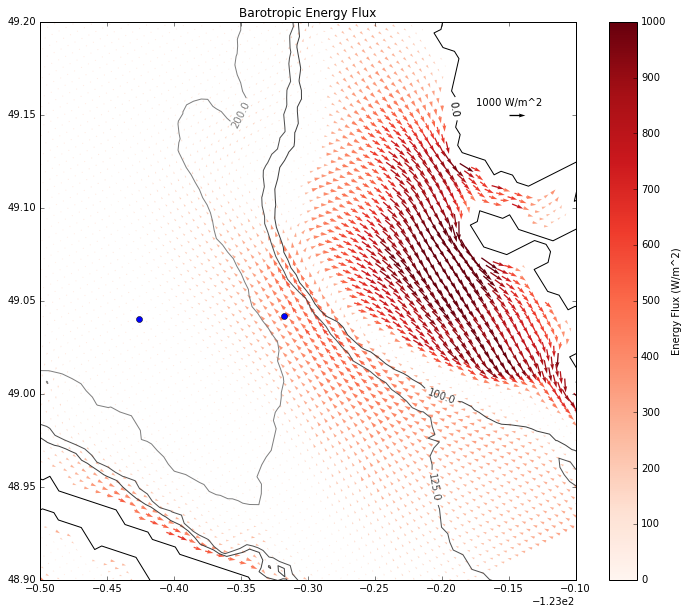

In [5]:
const='M2'
lons = sshstruc['lons'][0,0]
lats = sshstruc['lats'][0,0]

Fxbt,Fybt = ef.barotropic_flux(sshstruc, btstruc, const)
mag = np.sqrt(Fxbt**2+Fybt**2)
fig,ax=plt.subplots(1,1,figsize=(12,10))
q=ax.quiver(lons,lats,Fxbt,Fybt,mag,cmap='Reds',clim=[0,1000])
ax.set_xlim([-123.5,-123.1])
ax.set_ylim([48.9,49.2])
ax.set_title('Barotropic Energy Flux')
ax.quiverkey(q,-123.15,49.15,1000,'1000 W/m^2',color='k', coordinates='data')
cbar=plt.colorbar(q,ax=ax)
cbar.set_label('Energy Flux (W/m^2)')
C=ax.contour(NEMO_lons,NEMO_lats,bathy.data,[0,100,125,200], cmap='gray',vmin=0,vmax=400)
manuel_locations=[(-123.2,49.15),(-123.2,49),(-123.2,48.95),(-123.35,49.15)]
plt.clabel(C,fmt='%1.1f',ax=ax,manual=manuel_locations)
for site in sites:
    ax.plot(SITES[site]['lon'],SITES[site]['lat'],'bo')

Depth-integrated will be more useful... More on this later.

# Baroclinic - M2
Near surface

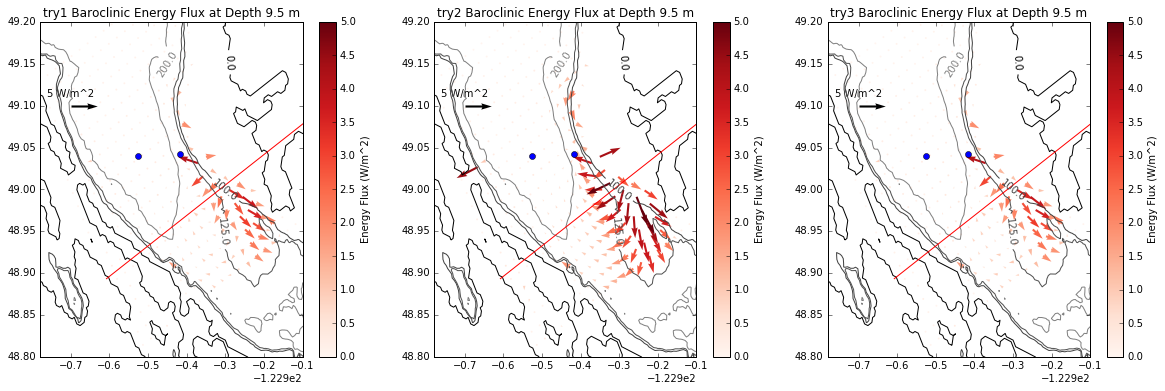

In [6]:
depths = pbc_t_struc['deptht'][0,0][:,0]
jstart,istart = ef.find_starting_index(NEMO_lons,NEMO_lats,lons[0,0],lats[0,0])

d=9
fig,axs=plt.subplots(1,3,figsize=(20,6))

names = ['try1', 'try2', 'try3']
strucs = [pbc_t_struc, pbc_struc2, pbc_struc3]
st=4
for ax, name, struc in zip(axs, names, strucs):
    if name == 'try2':
        Fxbc,Fybc = ef.baroclinic_flux_try2(struc, bcstruc,const)
    else:
        Fxbc,Fybc = ef.baroclinic_flux(struc, bcstruc,const)

    mag = np.sqrt(Fxbc[:,:,d]**2+Fybc[:,:,d]**2)
    q = ax.quiver(lons[::st,::st],lats[::st,::st],Fxbc[::st,::st,d],Fybc[::st,::st,d],
                  mag[::st,::st],cmap='Reds',clim=[0,5],scale=5*10,width=0.008)
    ax.set_title(name +' Baroclinic Energy Flux at Depth {0:.3g} m'.format(depths[d]))
    ax.quiverkey(q,-123.6,49.1,5,'5 W/m^2',color='k', coordinates='data')
    cbar=plt.colorbar(q,ax=ax)
    cbar.set_label('Energy Flux (W/m^2)')

    #labels and bathymetry
    ax.set_xlim([-123.68,-123])
    ax.set_ylim([48.8,49.2])
    j=22
    ax.plot([NEMO_lons[j+jstart,istart], NEMO_lons[j+jstart,-1]], 
            [NEMO_lats[j+jstart,istart], NEMO_lats[j+jstart,-1]],'r')
    C=ax.contour(NEMO_lons,NEMO_lats,bathy.data,[0,100,125,200], cmap='gray',vmin=0,vmax=400)
    plt.clabel(C,fmt='%1.1f',ax=ax,manual=manuel_locations)
    for site in sites:
        ax.plot(SITES[site]['lon'],SITES[site]['lat'],'bo')
    


## 100 m

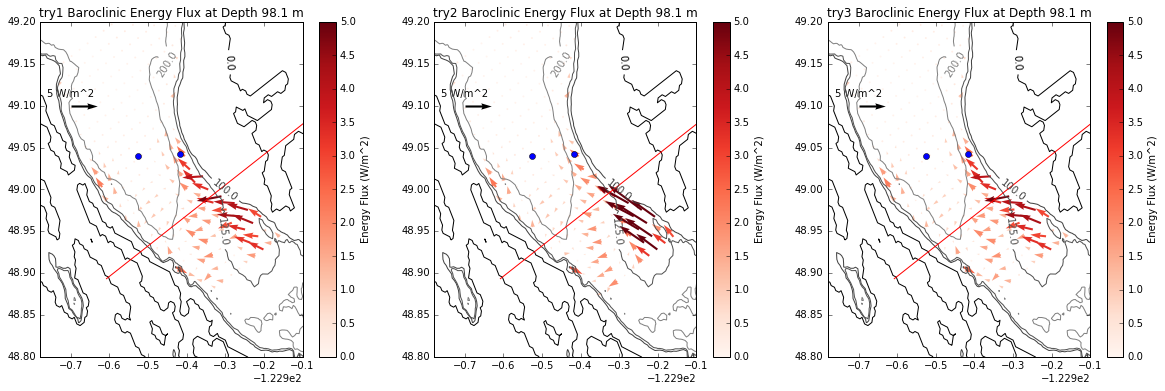

In [7]:
d=26
fig,axs=plt.subplots(1,3,figsize=(20,6))

st=4
for ax, name, struc in zip(axs, names, strucs):
    if name == 'try2':
        Fxbc,Fybc = ef.baroclinic_flux_try2(struc, bcstruc,const)
    else:
        Fxbc,Fybc = ef.baroclinic_flux(struc, bcstruc,const)

    mag = np.sqrt(Fxbc[:,:,d]**2+Fybc[:,:,d]**2)
    q = ax.quiver(lons[::st,::st],lats[::st,::st],Fxbc[::st,::st,d],Fybc[::st,::st,d],
                  mag[::st,::st],cmap='Reds',clim=[0,5],scale=5*10,width=0.008)
    ax.set_title(name +' Baroclinic Energy Flux at Depth {0:.3g} m'.format(depths[d]))
    ax.quiverkey(q,-123.6,49.1,5,'5 W/m^2',color='k', coordinates='data')
    cbar=plt.colorbar(q,ax=ax)
    cbar.set_label('Energy Flux (W/m^2)')

    #labels and bathymetry
    ax.set_xlim([-123.68,-123])
    ax.set_ylim([48.8,49.2])
    j=22
    ax.plot([NEMO_lons[j+jstart,istart], NEMO_lons[j+jstart,-1]], 
            [NEMO_lats[j+jstart,istart], NEMO_lats[j+jstart,-1]],'r')
    C=ax.contour(NEMO_lons,NEMO_lats,bathy.data,[0,100,125,200], cmap='gray',vmin=0,vmax=400)
    plt.clabel(C,fmt='%1.1f',ax=ax,manual=manuel_locations)
    for site in sites:
        ax.plot(SITES[site]['lon'],SITES[site]['lat'],'bo')
    


## Plotting in NEMO coords

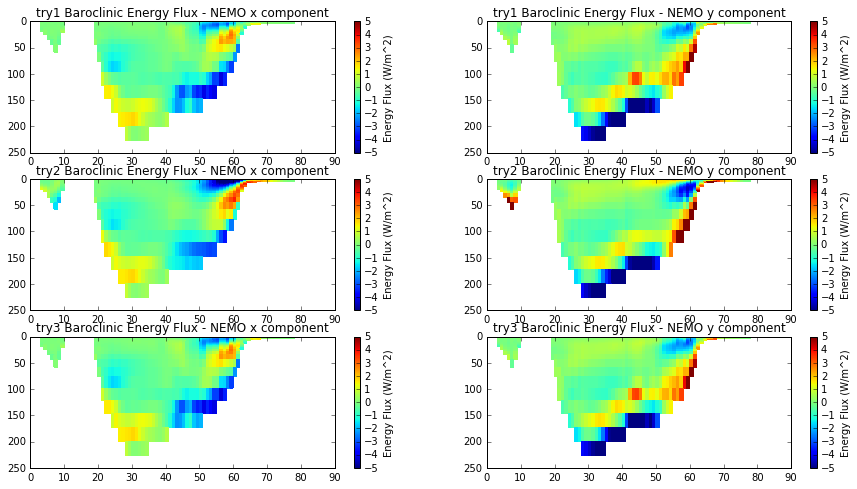

In [8]:
theta_rad = np.deg2rad(29)
row=0
fig,axs=plt.subplots(3,2,figsize=(15,8))
for name, struc in zip(names, strucs):
    if name == 'try2':
        Fxbc,Fybc = ef.baroclinic_flux_try2(struc, bcstruc,const)
    else:
        Fxbc,Fybc = ef.baroclinic_flux(struc, bcstruc,const)

    Fx_NEMO=  Fxbc * np.cos(theta_rad) + Fybc * np.sin(theta_rad)
    Fy_NEMO = -Fxbc * np.sin(theta_rad) + Fybc * np.cos(theta_rad)
    j=22
    ax=axs[row,0]
    mesh=ax.pcolormesh(np.arange(Fx_NEMO.shape[0]),depths,Fx_NEMO[:,j,:].T,vmin=-5,vmax=5)
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label('Energy Flux (W/m^2)')
    ax.set_title(name +' Baroclinic Energy Flux - NEMO x component')
    ax.set_ylim([250,0])
    ax=axs[row,1]
    mesh=ax.pcolormesh(np.arange(Fy_NEMO.shape[0]),depths,Fy_NEMO[:,j,:].T, vmin=-5,vmax=5)
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label('Energy Flux (W/m^2)')
    ax.set_title(name +' Baroclinic Energy Flux - NEMO y component')
    ax.set_ylim([250,0])
    row=row+1

Why are the values so large on the right side of the slope? Why are they in the negative y direction at depth?

### Profile at East

In [9]:
site='East'
i,j = figures.find_model_point(SITES[site]['lon'], SITES[site]['lat'], lons, lats,
                               tol_lon=0.004, tol_lat=0.002)

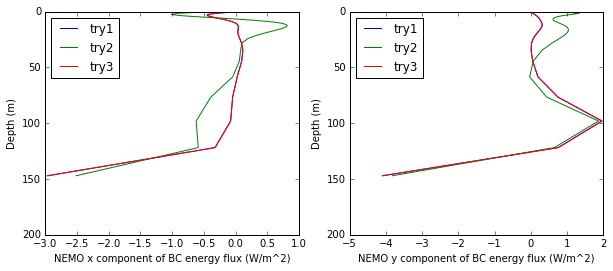

In [10]:
theta_rad = np.deg2rad(29)
row=0
fig,axs=plt.subplots(1,2,figsize=(10,4))

for name, struc in zip(names, strucs):
    if name == 'try2':
        Fxbc,Fybc = ef.baroclinic_flux_try2(struc, bcstruc,const)
    else:
        Fxbc,Fybc = ef.baroclinic_flux(struc, bcstruc,const)

    Fx_NEMO=  Fxbc * np.cos(theta_rad) + Fybc * np.sin(theta_rad)
    Fy_NEMO = -Fxbc * np.sin(theta_rad) + Fybc * np.cos(theta_rad)
    ax=axs[0]
    ax.plot(np.squeeze(Fx_NEMO[i,j,:]), depths, label=name)
    ax.set_xlabel('NEMO x component of BC energy flux (W/m^2)')
    ax.set_ylim([200,0])
    ax.legend(loc=0)
    ax.set_ylabel('Depth (m)')
    ax=axs[1]
    ax.plot(np.squeeze(Fy_NEMO[i,j,:]), depths, label=name)
    ax.set_xlabel('NEMO y component of BC energy flux (W/m^2)')
    ax.set_ylim([200,0])
    ax.legend(loc=0)
    ax.set_ylabel('Depth (m)')

Duh, the Kunze anc Cummins method are the same when I apply a harmonic analysis because they differ by only a constant. Maybe it is time to look at energy flux without the harmonic analysis?

# Depth Integrated
Barotropic

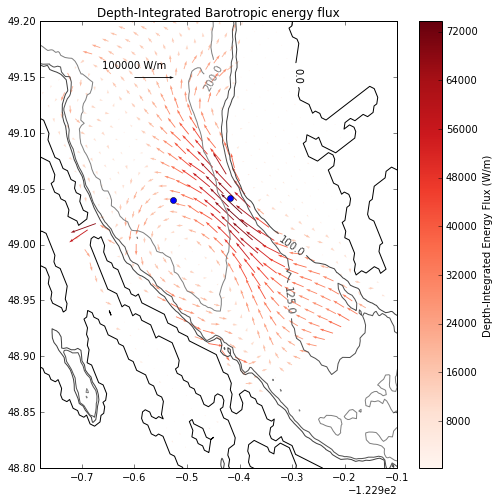

In [11]:
column_depth = ef.water_depth(tmask,e3t)
jend = jstart + Fxbt.shape[-1]
iend = istart + Fxbt.shape[0]

Fxbt_depint = Fxbt*column_depth[jstart:jend, istart:iend].T
Fybt_depint= Fybt*column_depth[jstart:jend, istart:iend].T


fig,ax=plt.subplots(1,1,figsize=(8,8))
st=3
#barotropic
bt_mag = np.sqrt(Fxbt_depint**2 + Fybt_depint**2)
q=ax.quiver(lons[::st,::st],lats[::st,::st],
            Fxbt_depint[::st,::st],Fybt_depint[::st,::st],bt_mag[::st,::st],
            cmap='Reds')
cbar=plt.colorbar(q,ax=ax)
cbar.set_label('Depth-Integrated Energy Flux (W/m)')
ax.set_title('Depth-Integrated Barotropic energy flux')
ax.quiverkey(q,-123.5,49.15,100000,'100000 W/m',color='k', coordinates='data')

C=ax.contour(NEMO_lons,NEMO_lats,bathy.data,[0,100,125,200], cmap='gray',vmin=0,vmax=400)
ax.set_xlim([-123.68,-123])
ax.set_ylim([48.8,49.2])
plt.clabel(C,fmt='%1.1f',ax=ax,manual=manuel_locations)
for site in sites:
    ax.plot(SITES[site]['lon'],SITES[site]['lat'],'bo')

Baroclinic

/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:10: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:11: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:12: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:13: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


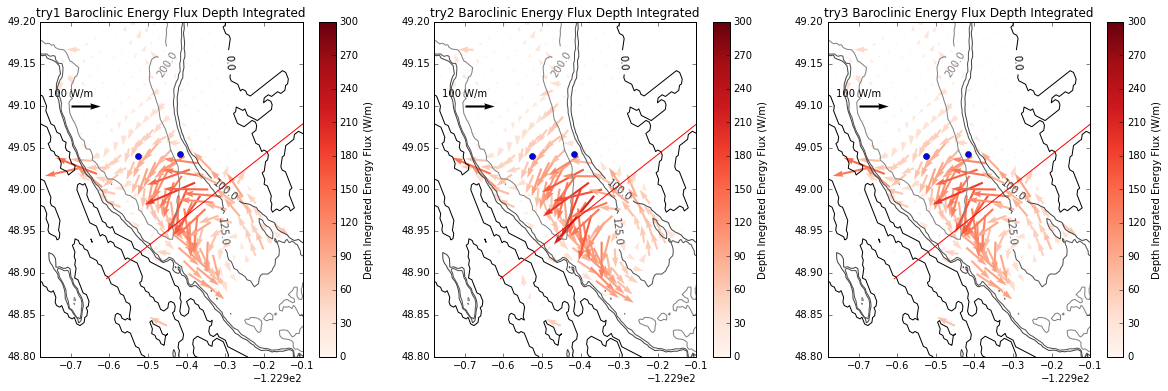

In [12]:
fig,axs=plt.subplots(1,3,figsize=(20,6))

st=4
for ax, name, struc in zip(axs, names, strucs):
    if name == 'try2':
        Fxbc,Fybc = ef.baroclinic_flux_try2(struc, bcstruc,const)
    else:
        Fxbc,Fybc = ef.baroclinic_flux(struc, bcstruc,const)

    Fxbc_depint = ef.depth_integrate(Fxbc, np.transpose(tmask[:,jstart:jend,istart:iend], (2,1,0)),
                              np.transpose(e3t[:,jstart:jend,istart:iend],(2,1,0)))
    Fybc_depint = ef.depth_integrate(Fybc, np.transpose(tmask[:,jstart:jend,istart:iend], (2,1,0)),
                              np.transpose(e3t[:,jstart:jend,istart:iend],(2,1,0)))
    mag = np.sqrt(Fxbc_depint**2 + Fybc_depint**2)
    q = ax.quiver(lons[::st,::st],lats[::st,::st],Fxbc_depint[::st,::st],Fybc_depint[::st,::st],
                  mag[::st,::st],cmap='Reds',clim=[0,300],scale=9*10**2,width=0.008)
    ax.set_title(name +' Baroclinic Energy Flux Depth Integrated'.format(depths[d]))
    ax.quiverkey(q,-123.6,49.1,100,'100 W/m',color='k', coordinates='data')
    cbar=plt.colorbar(q,ax=ax)
    cbar.set_label('Depth Inegrated Energy Flux (W/m)')

    #labels and bathymetry
    ax.set_xlim([-123.68,-123])
    ax.set_ylim([48.8,49.2])
    j=22
    ax.plot([NEMO_lons[j+jstart,istart], NEMO_lons[j+jstart,-1]], 
            [NEMO_lats[j+jstart,istart], NEMO_lats[j+jstart,-1]],'r')
    C=ax.contour(NEMO_lons,NEMO_lats,bathy.data,[0,100,125,200], cmap='gray',vmin=0,vmax=400)
    plt.clabel(C,fmt='%1.1f',ax=ax,manual=manuel_locations)
    for site in sites:
        ax.plot(SITES[site]['lon'],SITES[site]['lat'],'bo')

try 2 has a relatively small signal compared with the Kunze or Cummins method


# MSF - two week period
Why look at this? Stacey et al (1987) saw a strong MSF component in current measurements. Maybe this can help me decide if I have a sign error? If there is a 2 week period between renewal pulses, I think I should see baroclinic energy flux into the strait 

/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:13: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:15: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:16: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


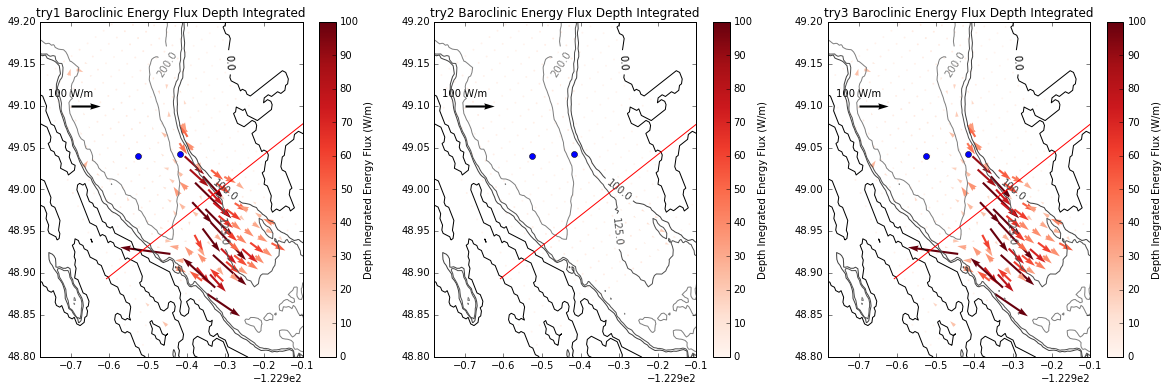

In [13]:
const='MSF'

fig,axs=plt.subplots(1,3,figsize=(20,6))

st=4
for ax, name, struc in zip(axs, names, strucs):

    if name == 'try2':
        Fxbc,Fybc = ef.baroclinic_flux_try2(struc, bcstruc,const)
    else:
        Fxbc,Fybc = ef.baroclinic_flux(struc, bcstruc,const)

    Fxbc_depint = ef.depth_integrate(Fxbc, np.transpose(tmask[:,jstart:jend,istart:iend], (2,1,0)),
                              np.transpose(e3t[:,jstart:jend,istart:iend],(2,1,0)))
    Fybc_depint = ef.depth_integrate(Fybc, np.transpose(tmask[:,jstart:jend,istart:iend], (2,1,0)),
                              np.transpose(e3t[:,jstart:jend,istart:iend],(2,1,0)))
    mag = np.sqrt(Fxbc_depint**2 + Fybc_depint**2)
    q = ax.quiver(lons[::st,::st],lats[::st,::st],Fxbc_depint[::st,::st],Fybc_depint[::st,::st],
                  mag[::st,::st],cmap='Reds',clim=[0,100],scale=9*10**2,width=0.008)
    ax.set_title(name +' Baroclinic Energy Flux Depth Integrated'.format(depths[d]))
    ax.quiverkey(q,-123.6,49.1,100,'100 W/m',color='k', coordinates='data')
    cbar=plt.colorbar(q,ax=ax)
    cbar.set_label('Depth Inegrated Energy Flux (W/m)')

    #labels and bathymetry
    ax.set_xlim([-123.68,-123])
    ax.set_ylim([48.8,49.2])

    j=22
    ax.plot([NEMO_lons[j+jstart,istart], NEMO_lons[j+jstart,-1]], 
            [NEMO_lats[j+jstart,istart], NEMO_lats[j+jstart,-1]],'r')
    C=ax.contour(NEMO_lons,NEMO_lats,bathy.data,[0,100,125,200], cmap='gray',vmin=0,vmax=400)
    plt.clabel(C,fmt='%1.1f',ax=ax,manual=manuel_locations)
    for site in sites:
        ax.plot(SITES[site]['lon'],SITES[site]['lat'],'bo')

Slice and rotate to baroclinic NEMO coordinates.

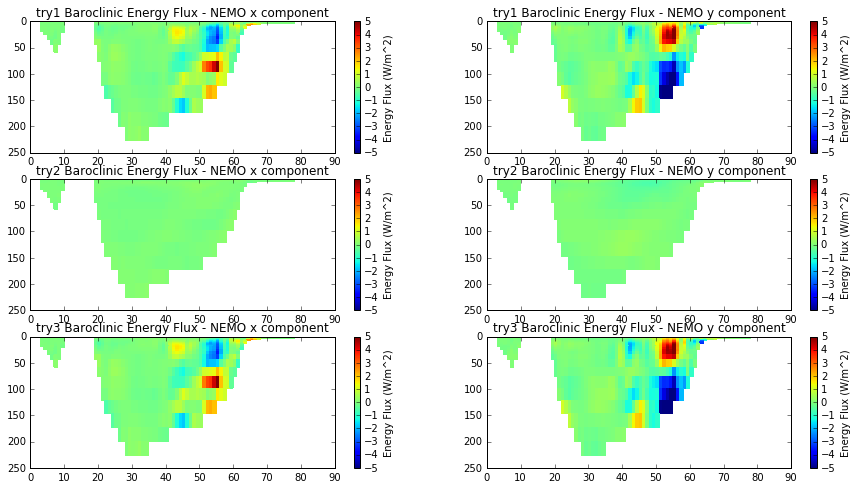

In [14]:
const = 'MSF'
theta_rad = np.deg2rad(29)
row=0
fig,axs=plt.subplots(3,2,figsize=(15,8))
for name, struc in zip(names, strucs):
    if name == 'try2':
        Fxbc,Fybc = ef.baroclinic_flux_try2(struc, bcstruc,const)
    else:
        Fxbc,Fybc = ef.baroclinic_flux(struc, bcstruc,const)

    Fx_NEMO=  Fxbc * np.cos(theta_rad) + Fybc * np.sin(theta_rad)
    Fy_NEMO = -Fxbc * np.sin(theta_rad) + Fybc * np.cos(theta_rad)

    j=22
    ax=axs[row,0]
    mesh=ax.pcolormesh(np.arange(Fx_NEMO.shape[0]),depths,Fx_NEMO[:,j,:].T,vmin=-5,vmax=5)
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label('Energy Flux (W/m^2)')
    ax.set_title(name +' Baroclinic Energy Flux - NEMO x component')
    ax.set_ylim([250,0])
    ax=axs[row,1]
    mesh=ax.pcolormesh(np.arange(Fy_NEMO.shape[0]),depths,Fy_NEMO[:,j,:].T, vmin=-5,vmax=5)
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label('Energy Flux (W/m^2)')
    ax.set_title(name +' Baroclinic Energy Flux - NEMO y component')
    ax.set_ylim([250,0])
    row=row+1


### MSF baroclinic 100 m depth

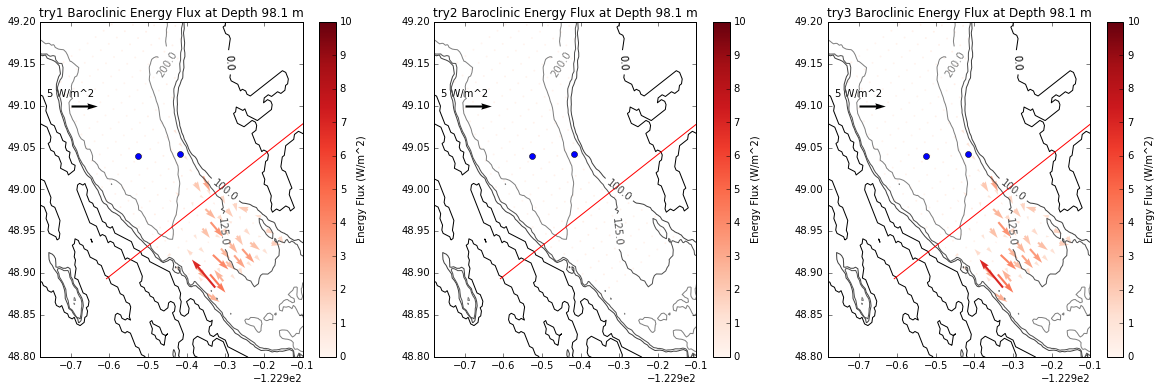

In [15]:
cons = 'MSF'
d=26
fig,axs=plt.subplots(1,3,figsize=(20,6))

st=4
for ax, name, struc in zip(axs, names, strucs):
    if name == 'try2':
        Fxbc,Fybc = ef.baroclinic_flux_try2(struc, bcstruc,const)
    else:
        Fxbc,Fybc = ef.baroclinic_flux(struc, bcstruc,const)

    mag = np.sqrt(Fxbc[:,:,d]**2+Fybc[:,:,d]**2)
    q = ax.quiver(lons[::st,::st],lats[::st,::st],Fxbc[::st,::st,d],Fybc[::st,::st,d],
                  mag[::st,::st],cmap='Reds',clim=[0,10],scale=5*10,width=0.008)
    ax.set_title(name +' Baroclinic Energy Flux at Depth {0:.3g} m'.format(depths[d]))
    ax.quiverkey(q,-123.6,49.1,5,'5 W/m^2',color='k', coordinates='data')
    cbar=plt.colorbar(q,ax=ax)
    cbar.set_label('Energy Flux (W/m^2)')

    #labels and bathymetry
    ax.set_xlim([-123.68,-123])
    ax.set_ylim([48.8,49.2])
    j=22
    ax.plot([NEMO_lons[j+jstart,istart], NEMO_lons[j+jstart,-1]], 
            [NEMO_lats[j+jstart,istart], NEMO_lats[j+jstart,-1]],'r')
    C=ax.contour(NEMO_lons,NEMO_lats,bathy.data,[0,100,125,200], cmap='gray',vmin=0,vmax=400)
    plt.clabel(C,fmt='%1.1f',ax=ax,manual=manuel_locations)
    for site in sites:
        ax.plot(SITES[site]['lon'],SITES[site]['lat'],'bo')
    


# K1

/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:13: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:14: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:15: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/home/nsoontie/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:16: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


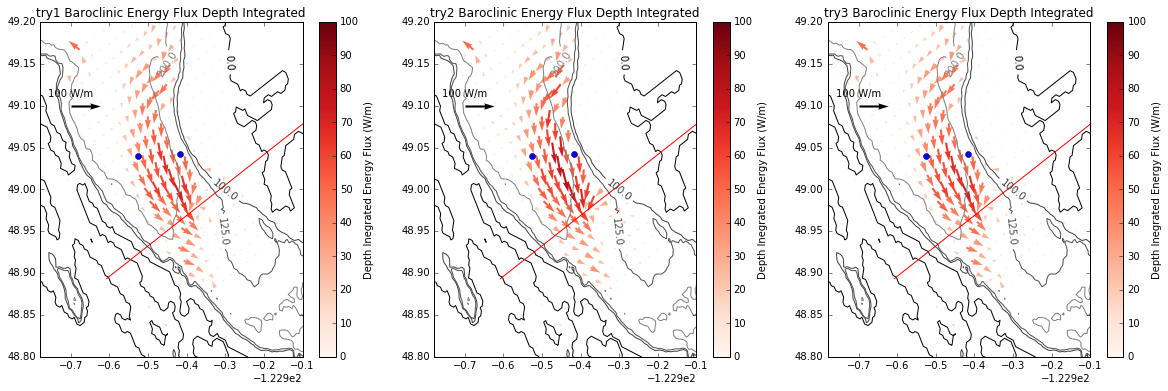

In [16]:
const = 'K1'

fig,axs=plt.subplots(1,3,figsize=(20,6))

st=4
for ax, name, struc in zip(axs, names, strucs):

    if name == 'try2':
        Fxbc,Fybc = ef.baroclinic_flux_try2(struc, bcstruc,const)
    else:
        Fxbc,Fybc = ef.baroclinic_flux(struc, bcstruc,const)

    Fxbc_depint = ef.depth_integrate(Fxbc, np.transpose(tmask[:,jstart:jend,istart:iend], (2,1,0)),
                              np.transpose(e3t[:,jstart:jend,istart:iend],(2,1,0)))
    Fybc_depint = ef.depth_integrate(Fybc, np.transpose(tmask[:,jstart:jend,istart:iend], (2,1,0)),
                              np.transpose(e3t[:,jstart:jend,istart:iend],(2,1,0)))
    mag = np.sqrt(Fxbc_depint**2 + Fybc_depint**2)
    q = ax.quiver(lons[::st,::st],lats[::st,::st],Fxbc_depint[::st,::st],Fybc_depint[::st,::st],
                  mag[::st,::st],cmap='Reds',clim=[0,100],scale=9*10**2,width=0.008)
    ax.set_title(name +' Baroclinic Energy Flux Depth Integrated'.format(depths[d]))
    ax.quiverkey(q,-123.6,49.1,100,'100 W/m',color='k', coordinates='data')
    cbar=plt.colorbar(q,ax=ax)
    cbar.set_label('Depth Inegrated Energy Flux (W/m)')

    #labels and bathymetry
    ax.set_xlim([-123.68,-123])
    ax.set_ylim([48.8,49.2])

    j=22
    ax.plot([NEMO_lons[j+jstart,istart], NEMO_lons[j+jstart,-1]], 
            [NEMO_lats[j+jstart,istart], NEMO_lats[j+jstart,-1]],'r')
    C=ax.contour(NEMO_lons,NEMO_lats,bathy.data,[0,100,125,200], cmap='gray',vmin=0,vmax=400)
    plt.clabel(C,fmt='%1.1f',ax=ax,manual=manuel_locations)
    for site in sites:
        ax.plot(SITES[site]['lon'],SITES[site]['lat'],'bo')

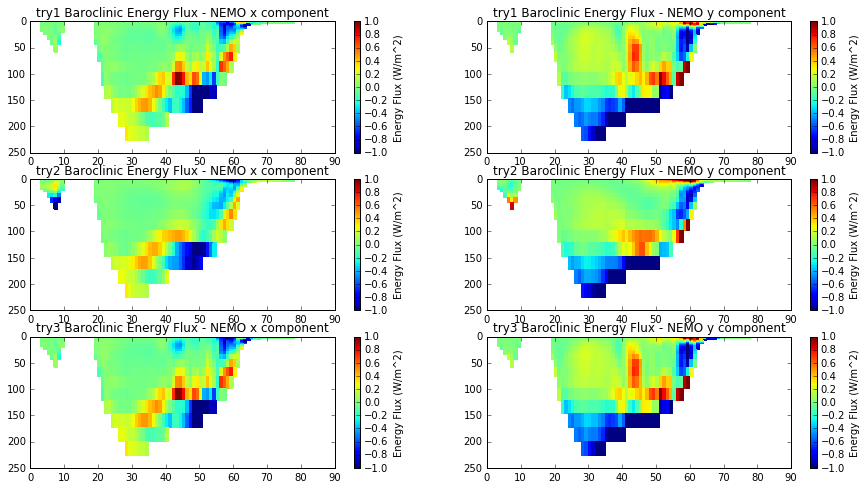

In [17]:
const ='K1'
theta_rad = np.deg2rad(29)
row=0
fig,axs=plt.subplots(3,2,figsize=(15,8))
for name, struc in zip(names, strucs):
    if name == 'try2':
        Fxbc,Fybc = ef.baroclinic_flux_try2(struc, bcstruc,const)
    else:
        Fxbc,Fybc = ef.baroclinic_flux(struc, bcstruc,const)

    Fx_NEMO=  Fxbc * np.cos(theta_rad) + Fybc * np.sin(theta_rad)
    Fy_NEMO = -Fxbc * np.sin(theta_rad) + Fybc * np.cos(theta_rad)

    j=22
    ax=axs[row,0]
    mesh=ax.pcolormesh(np.arange(Fx_NEMO.shape[0]),depths,Fx_NEMO[:,j,:].T,vmin=-1,vmax=1)
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label('Energy Flux (W/m^2)')
    ax.set_title(name +' Baroclinic Energy Flux - NEMO x component')
    ax.set_ylim([250,0])
    ax=axs[row,1]
    mesh=ax.pcolormesh(np.arange(Fy_NEMO.shape[0]),depths,Fy_NEMO[:,j,:].T, vmin=-1,vmax=1)
    cbar=plt.colorbar(mesh,ax=ax)
    cbar.set_label('Energy Flux (W/m^2)')
    ax.set_title(name +' Baroclinic Energy Flux - NEMO y component')
    ax.set_ylim([250,0])
    row=row+1

## K1 at 150m

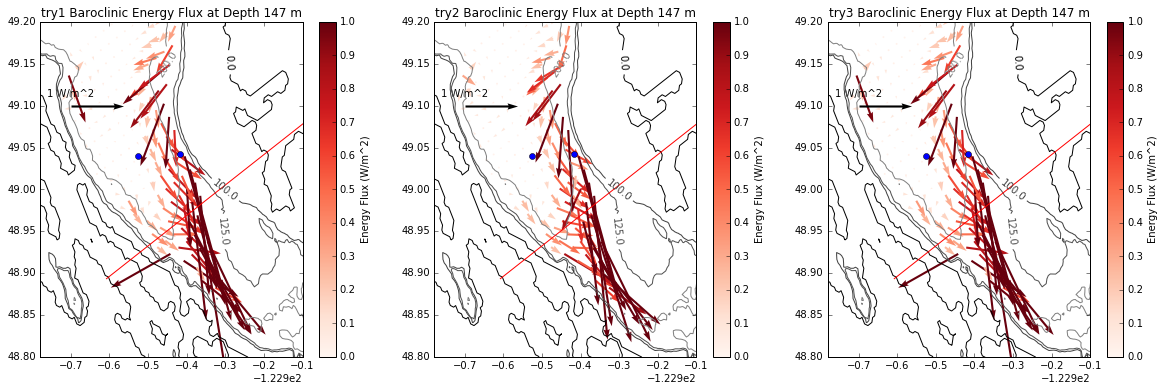

In [18]:
d=28


fig,axs=plt.subplots(1,3,figsize=(20,6))

st=4
for ax, name, struc in zip(axs, names, strucs):
    if name == 'try2':
        Fxbc,Fybc = ef.baroclinic_flux_try2(struc, bcstruc,const)
    else:
        Fxbc,Fybc = ef.baroclinic_flux(struc, bcstruc,const)

    mag = np.sqrt(Fxbc[:,:,d]**2+Fybc[:,:,d]**2)
    q = ax.quiver(lons[::st,::st],lats[::st,::st],Fxbc[::st,::st,d],Fybc[::st,::st,d],
                  mag[::st,::st],cmap='Reds',clim=[0,1],scale=5*10**0,width=0.008)
    ax.set_title(name +' Baroclinic Energy Flux at Depth {0:.3g} m'.format(depths[d]))
    ax.quiverkey(q,-123.6,49.1,1,'1 W/m^2',color='k', coordinates='data')
    cbar=plt.colorbar(q,ax=ax)
    cbar.set_label('Energy Flux (W/m^2)')

    #labels and bathymetry
    ax.set_xlim([-123.68,-123])
    ax.set_ylim([48.8,49.2])
    j=22
    ax.plot([NEMO_lons[j+jstart,istart], NEMO_lons[j+jstart,-1]], 
            [NEMO_lats[j+jstart,istart], NEMO_lats[j+jstart,-1]],'r')
    C=ax.contour(NEMO_lons,NEMO_lats,bathy.data,[0,100,125,200], cmap='gray',vmin=0,vmax=400)
    plt.clabel(C,fmt='%1.1f',ax=ax,manual=manuel_locations)
    for site in sites:
        ax.plot(SITES[site]['lon'],SITES[site]['lat'],'bo')

## Barotropic K1

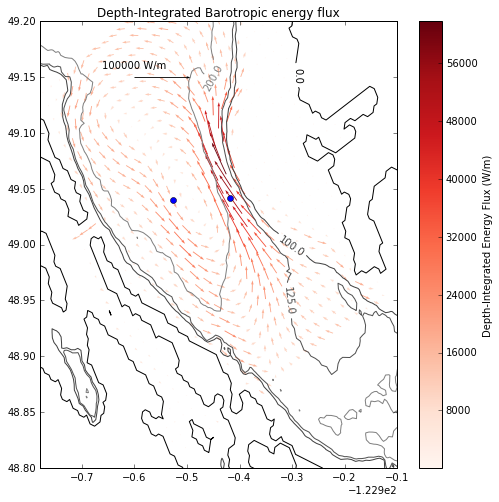

In [19]:
lons = sshstruc['lons'][0,0]
lats = sshstruc['lats'][0,0]

Fxbt,Fybt = ef.barotropic_flux(sshstruc, btstruc, const)
jend = jstart + Fxbt.shape[-1]
iend = istart + Fxbt.shape[0]

Fxbt_depint = Fxbt*column_depth[jstart:jend, istart:iend].T
Fybt_depint= Fybt*column_depth[jstart:jend, istart:iend].T


fig,ax=plt.subplots(1,1,figsize=(8,8))
st=3
#barotropic
bt_mag = np.sqrt(Fxbt_depint**2 + Fybt_depint**2)
q=ax.quiver(lons[::st,::st],lats[::st,::st],
            Fxbt_depint[::st,::st],Fybt_depint[::st,::st],bt_mag[::st,::st],
            cmap='Reds')
cbar=plt.colorbar(q,ax=ax)
cbar.set_label('Depth-Integrated Energy Flux (W/m)')
ax.set_title('Depth-Integrated Barotropic energy flux')
ax.quiverkey(q,-123.5,49.15,100000,'100000 W/m',color='k', coordinates='data')

C=ax.contour(NEMO_lons,NEMO_lats,bathy.data,[0,100,125,200], cmap='gray',vmin=0,vmax=400)
ax.set_xlim([-123.68,-123])
ax.set_ylim([48.8,49.2])
plt.clabel(C,fmt='%1.1f',ax=ax,manual=manuel_locations)
for site in sites:
    ax.plot(SITES[site]['lon'],SITES[site]['lat'],'bo')